# Exploratory Data Analysis
## Imports and Setup

In [11]:
from pathlib import Path

import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.ndimage import rotate, shift, zoom
from tqdm import tqdm

from dataloader import extract_patch

sns.set_style("white")

## Loading Data

In [12]:
train_df = pd.read_csv("../data/luna23-ismi-train-set.csv")
train_images_path = Path("../data/train_set/images/")
train_labels_path = Path("../data/train_set/labels/")
test_images_path = Path("../data/test_set/images/")

## Training Data Overview

In [13]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687 entries, 0 to 686
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   patientid    687 non-null    object 
 1   seriesuid    687 non-null    object 
 2   noduleid     687 non-null    object 
 3   coordx       687 non-null    float64
 4   coordy       687 non-null    float64
 5   coordz       687 non-null    float64
 6   diameter_mm  687 non-null    float64
 7   noduletype   687 non-null    object 
 8   malignancy   687 non-null    int64  
dtypes: float64(4), int64(1), object(4)
memory usage: 48.4+ KB
None


In [14]:
print(train_df.describe())

           coordx      coordy       coordz  diameter_mm  malignancy
count  687.000000  687.000000   687.000000   687.000000  687.000000
mean   -11.626405    1.502551  -147.941640    11.334056    0.308588
std     82.472533  101.201552   286.895552     8.166734    0.462247
min   -160.957052 -275.638639  -761.230892     2.585936    0.000000
25%    -82.792990  -58.398696  -221.441811     6.054301    0.000000
50%    -42.629914   15.660336  -162.929910     7.826399    0.000000
75%     70.750996   65.827064  -107.672673    14.007376    1.000000
max    146.824676  248.822439  1790.471720    49.944620    1.000000


In [15]:
print("Missing Values in Training Set")
print(train_df.isnull().sum())

Missing Values in Training Set
patientid      0
seriesuid      0
noduleid       0
coordx         0
coordy         0
coordz         0
diameter_mm    0
noduletype     0
malignancy     0
dtype: int64


## Class Imbalance Analysis

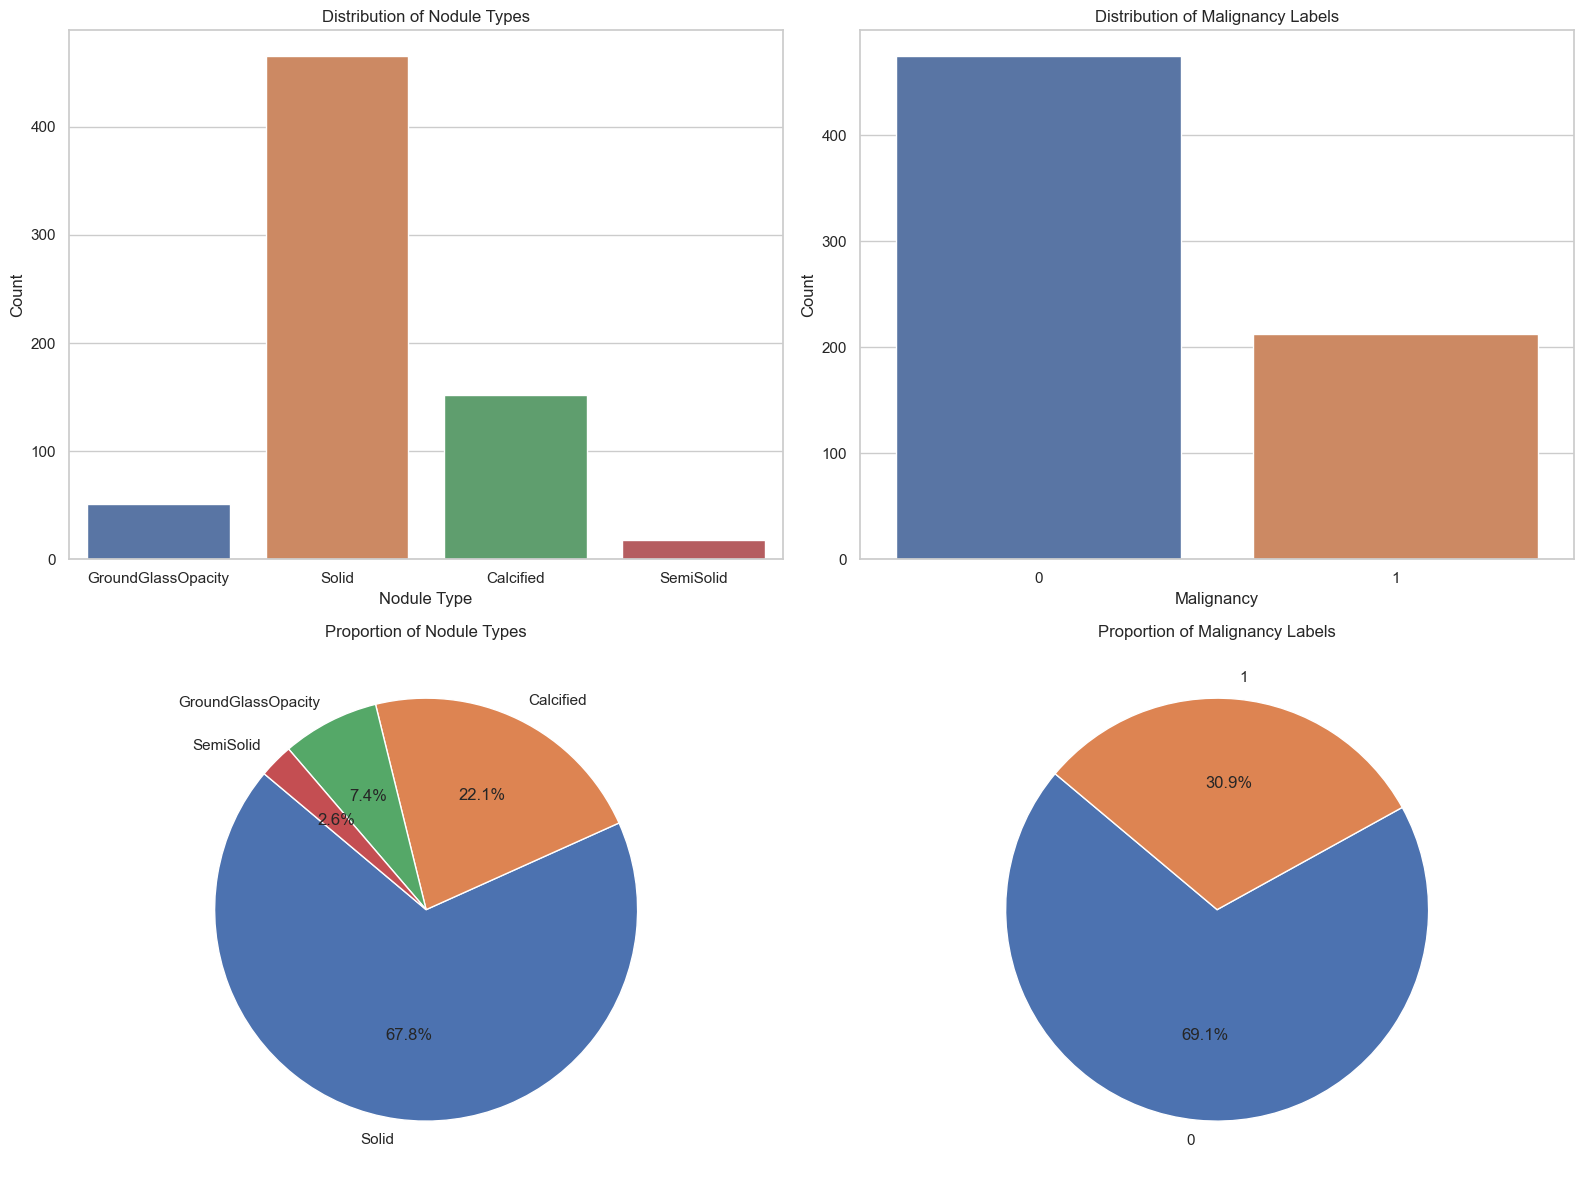

In [16]:
# Set style for seaborn
sns.set(style="whitegrid")

# Class Distribution Count Plots
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

# Count plots
sns.countplot(x='noduletype', data=train_df, ax=ax[0, 0])
ax[0, 0].set_title('Distribution of Nodule Types')
ax[0, 0].set_xlabel('Nodule Type')
ax[0, 0].set_ylabel('Count')

sns.countplot(x='malignancy', data=train_df, ax=ax[0, 1])
ax[0, 1].set_title('Distribution of Malignancy Labels')
ax[0, 1].set_xlabel('Malignancy')
ax[0, 1].set_ylabel('Count')

# Proportion Pie Charts
noduletype_counts = train_df['noduletype'].value_counts()
malignancy_counts = train_df['malignancy'].value_counts()

ax[1, 0].pie(noduletype_counts, labels=noduletype_counts.index, autopct='%1.1f%%', startangle=140)
ax[1, 0].set_title('Proportion of Nodule Types')

ax[1, 1].pie(malignancy_counts, labels=malignancy_counts.index, autopct='%1.1f%%', startangle=140)
ax[1, 1].set_title('Proportion of Malignancy Labels')

plt.tight_layout()
plt.show()

In [17]:
# Display Class Balance Metrics
noduletype_percentages = noduletype_counts / noduletype_counts.sum() * 100
malignancy_percentages = malignancy_counts / malignancy_counts.sum() * 100

print("Nodule Type Percentages:")
print(noduletype_percentages)

print("\nMalignancy Percentages:")
print(malignancy_percentages)

Nodule Type Percentages:
Solid                 67.831150
Calcified             22.125182
GroundGlassOpacity     7.423581
SemiSolid              2.620087
Name: noduletype, dtype: float64

Malignancy Percentages:
0    69.141194
1    30.858806
Name: malignancy, dtype: float64


## Training and Test Data Differences

In [18]:
# Function to get image statistics
def get_image_stats(image_path):
    image = sitk.ReadImage(str(image_path))
    image_array = sitk.GetArrayFromImage(image)
    return {
        'mean': np.mean(image_array),
        'std': np.std(image_array),
        'min': np.min(image_array),
        'max': np.max(image_array)
    }


# Collect statistics for training images
train_stats = [get_image_stats(train_images_path / f"{row.noduleid}.mha") for _, row in train_df.iterrows()]

# Collect statistics for test images
test_image_files = list(test_images_path.glob("*.mha"))
test_stats = [get_image_stats(test_image) for test_image in test_image_files]

# Convert to DataFrame for comparison
train_stats_df = pd.DataFrame(train_stats)
test_stats_df = pd.DataFrame(test_stats)

In [19]:
print("\nTraining Image Statistics")
print(train_stats_df.describe())


Training Image Statistics
              mean          std          min          max
count   687.000000   687.000000   687.000000   687.000000
mean   -442.252477   462.466888 -1235.903930  1679.206696
std     150.508400    89.067705   591.888407   624.178444
min   -1034.814084   250.253339 -3024.000000   518.000000
25%    -552.297543   422.217174 -1024.000000  1267.500000
50%    -433.800611   451.419971 -1024.000000  1505.000000
75%    -332.166417   484.689653 -1024.000000  1935.000000
max     -30.335741  1244.587184  -950.000000  5245.000000


In [20]:
print("\nTest Image Statistics")
print(test_stats_df.describe())


Test Image Statistics
             mean         std          min          max
count  256.000000  256.000000   256.000000   256.000000
mean  -447.012154  465.383157 -1272.585938  1744.769531
std    142.179665   86.104044   637.712684   652.946238
min   -796.008406  274.025101 -3024.000000   460.000000
25%   -537.076520  426.116888 -1024.000000  1282.250000
50%   -442.487848  451.583882 -1024.000000  1600.000000
75%   -348.845023  482.654672 -1024.000000  2033.250000
max    -82.756891  948.513931  -986.000000  4309.000000


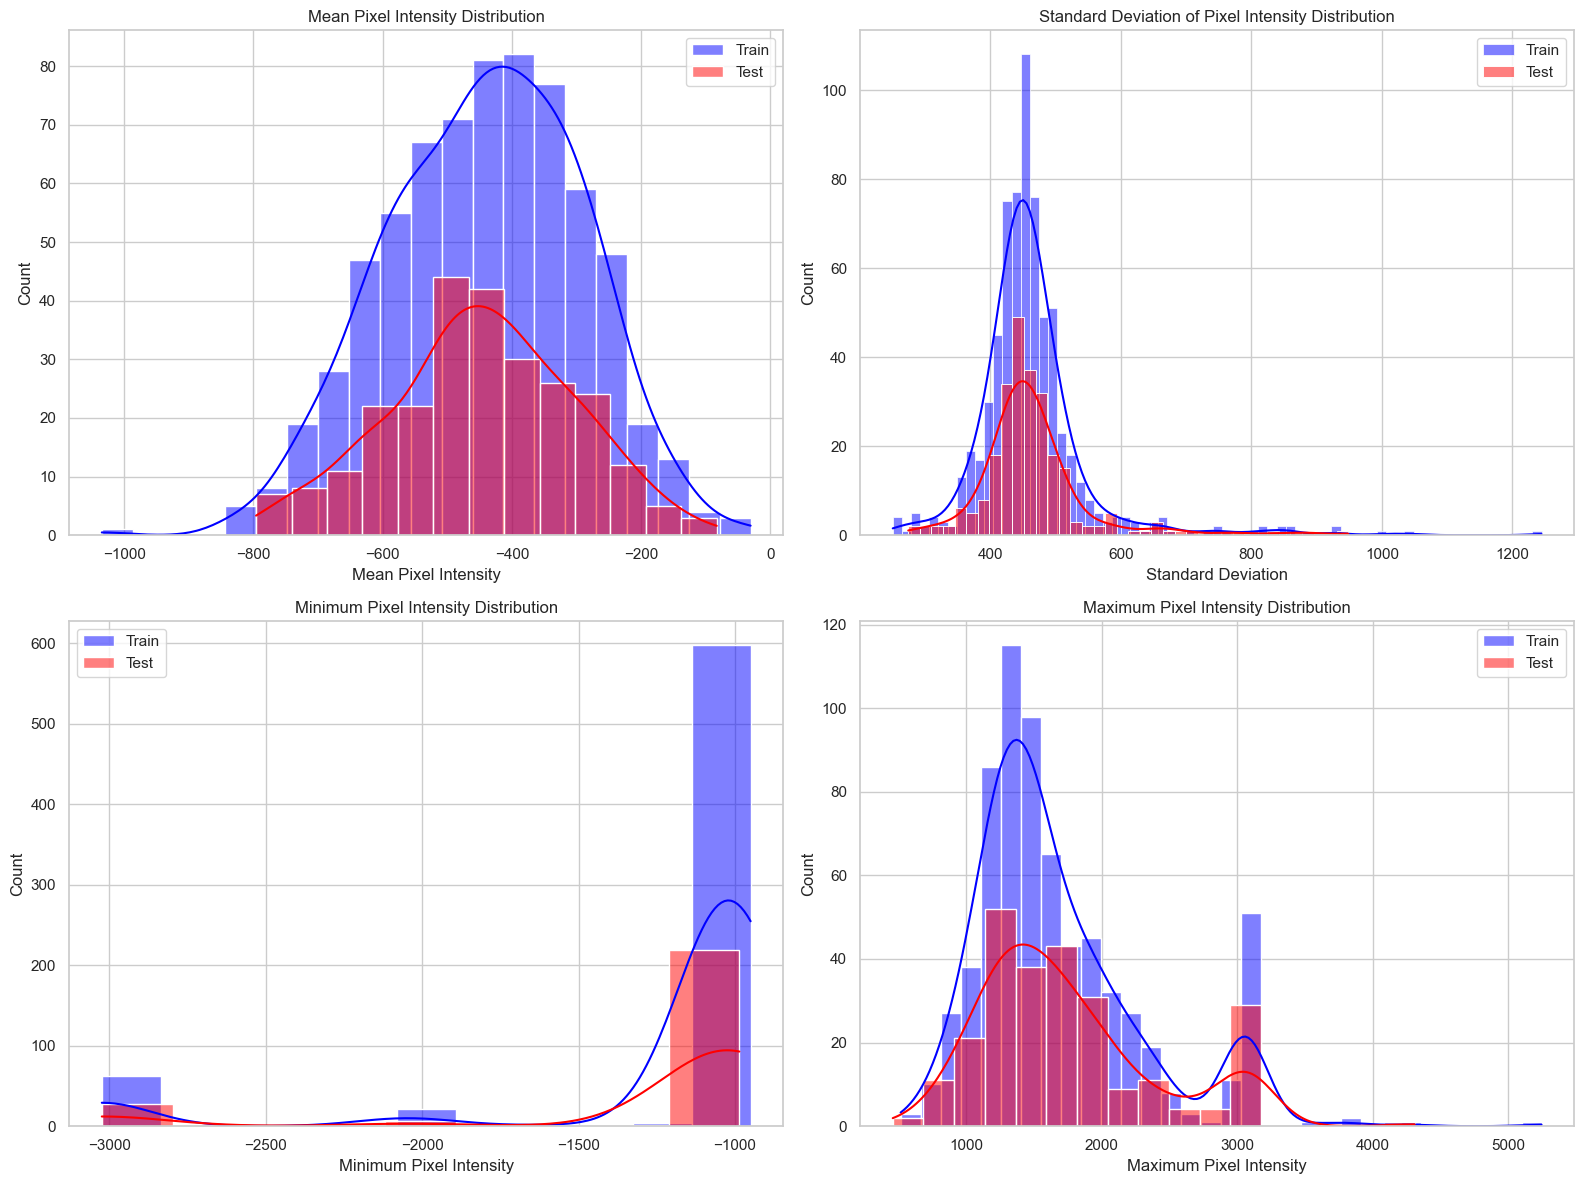

In [27]:
# Visualization of Image Statistics
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

# Mean
sns.histplot(train_stats_df['mean'], kde=True, color='blue', ax=ax[0, 0], label='Train')
sns.histplot(test_stats_df['mean'], kde=True, color='red', ax=ax[0, 0], label='Test')
ax[0, 0].set_title('Mean Pixel Intensity Distribution')
ax[0, 0].set_xlabel('Mean Pixel Intensity')
ax[0, 0].set_ylabel('Count')
ax[0, 0].legend()

# Standard Deviation
sns.histplot(train_stats_df['std'], kde=True, color='blue', ax=ax[0, 1], label='Train')
sns.histplot(test_stats_df['std'], kde=True, color='red', ax=ax[0, 1], label='Test')
ax[0, 1].set_title('Standard Deviation of Pixel Intensity Distribution')
ax[0, 1].set_xlabel('Standard Deviation')
ax[0, 1].set_ylabel('Count')
ax[0, 1].legend()

# Min Intensity
sns.histplot(train_stats_df['min'], kde=True, color='blue', ax=ax[1, 0], label='Train')
sns.histplot(test_stats_df['min'], kde=True, color='red', ax=ax[1, 0], label='Test')
ax[1, 0].set_title('Minimum Pixel Intensity Distribution')
ax[1, 0].set_xlabel('Minimum Pixel Intensity')
ax[1, 0].set_ylabel('Count')
ax[1, 0].legend()

# Max Intensity
sns.histplot(train_stats_df['max'], kde=True, color='blue', ax=ax[1, 1], label='Train')
sns.histplot(test_stats_df['max'], kde=True, color='red', ax=ax[1, 1], label='Test')
ax[1, 1].set_title('Maximum Pixel Intensity Distribution')
ax[1, 1].set_xlabel('Maximum Pixel Intensity')
ax[1, 1].set_ylabel('Count')
ax[1, 1].legend()

plt.tight_layout()
plt.show()

## Data Standardization - Intensity Normalization

Nodule ID: 2.25.85475102690801320257961710717610351452149165630150549062494, Nodule Type: GroundGlassOpacity, Malignancy: 0
Original Intensity Range: min=-960, max=359
Normalized Intensity Range: min=0.0, max=1.0


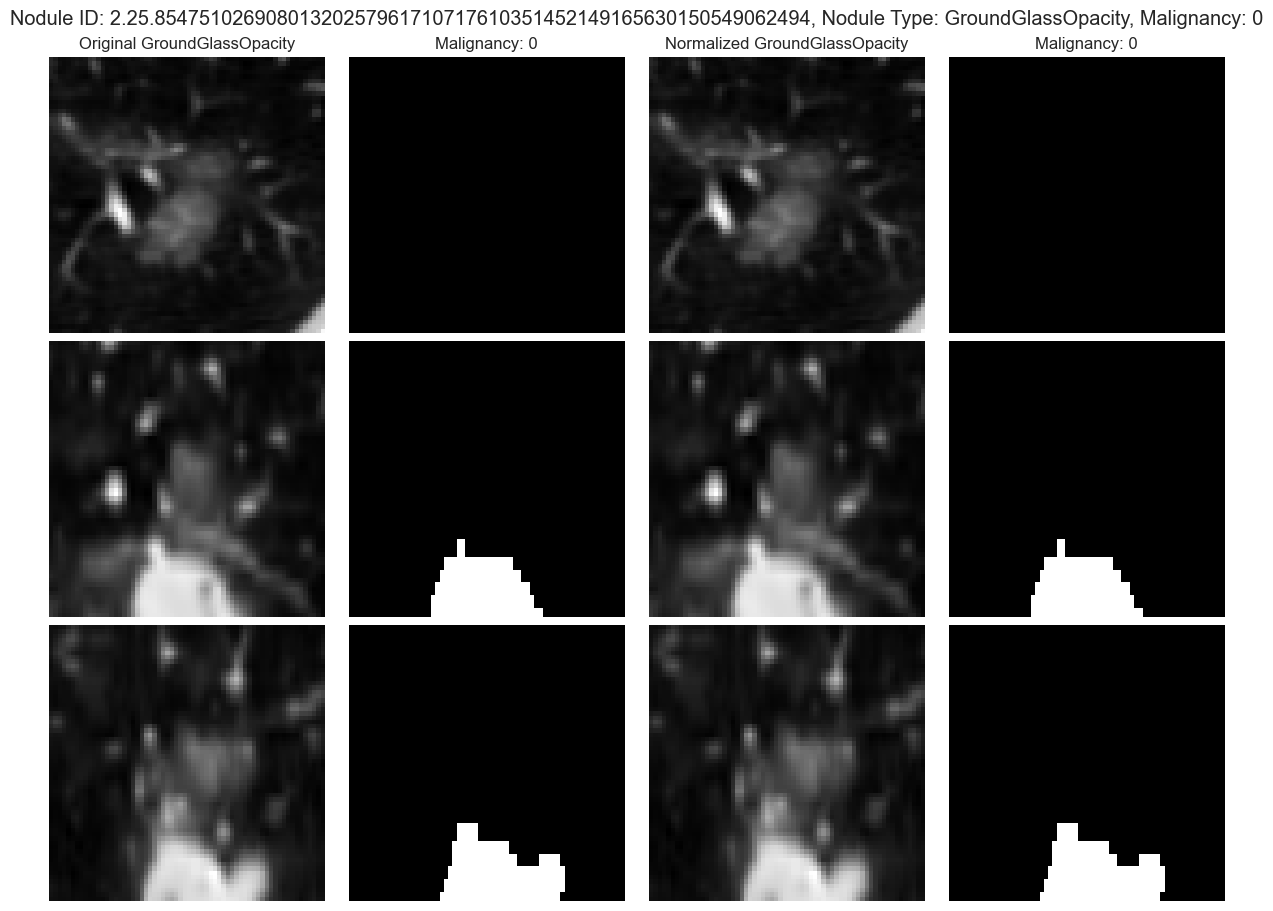

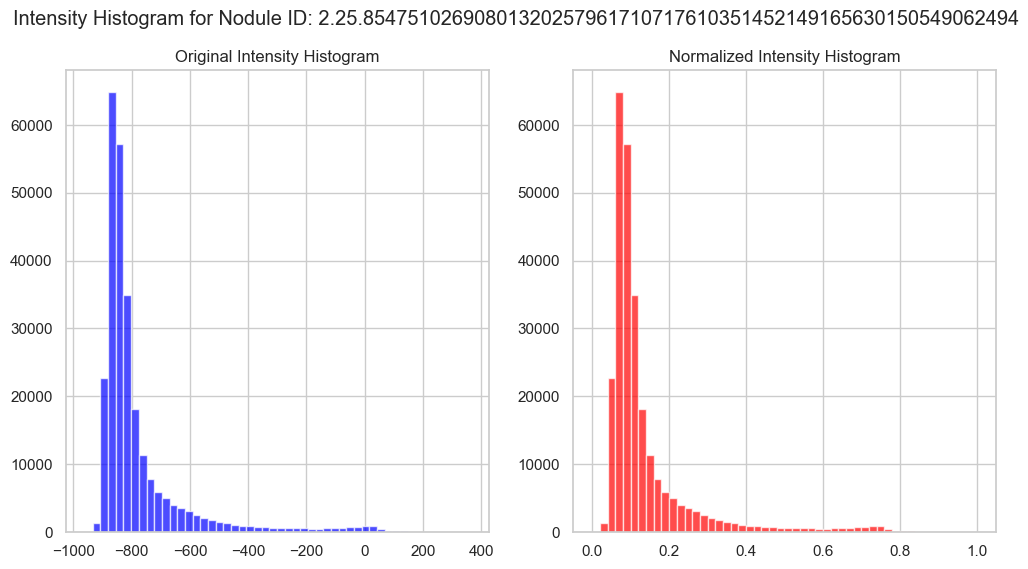

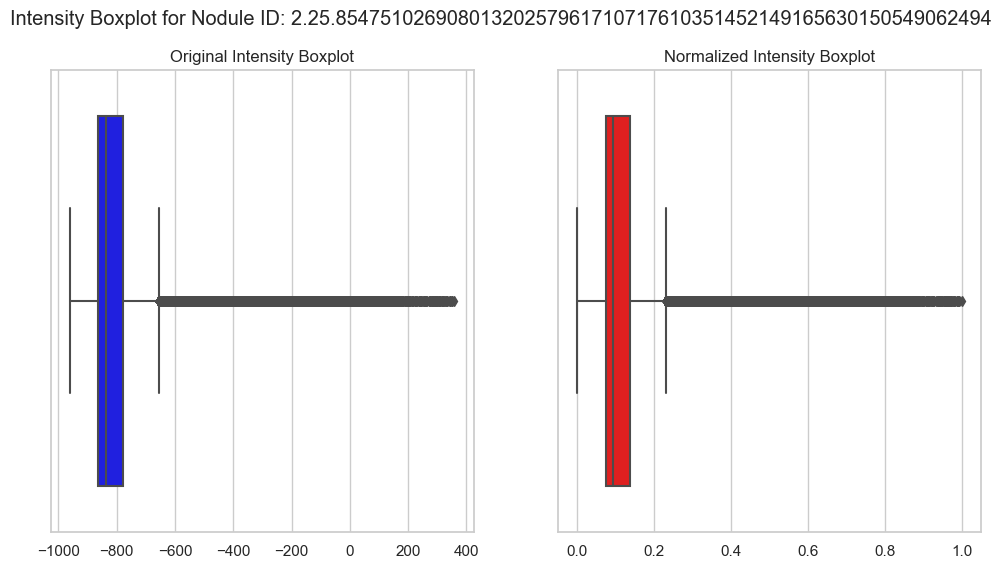

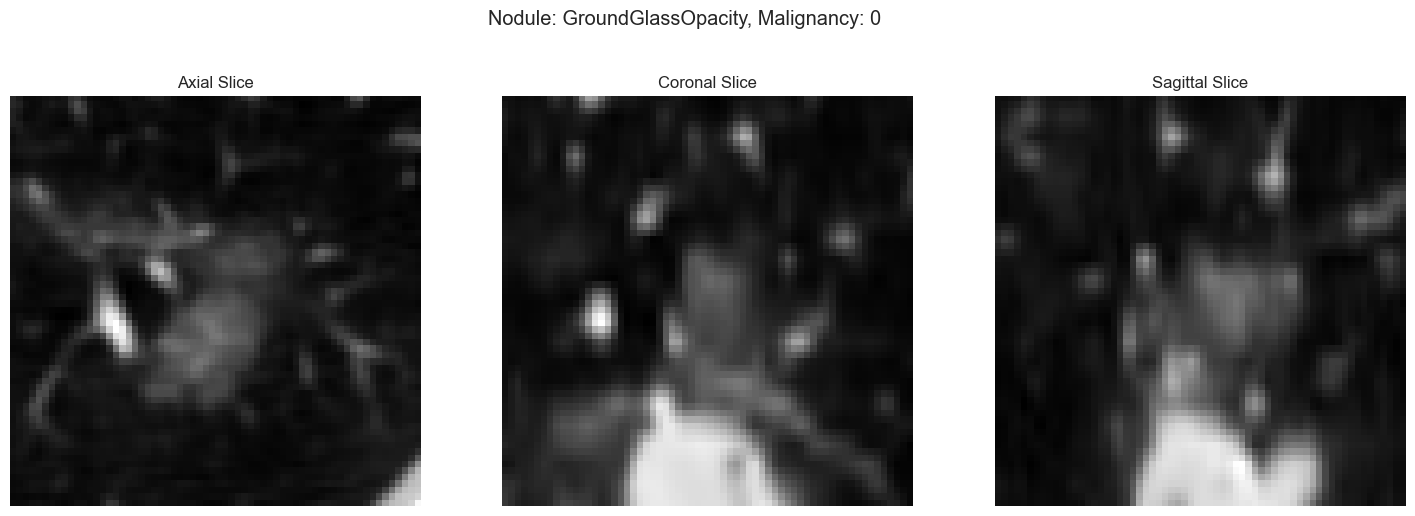

Nodule ID: 2.25.84860154576590236162618433953824299746847489441249362405484, Nodule Type: Solid, Malignancy: 1
Original Intensity Range: min=-966, max=843
Normalized Intensity Range: min=0.0, max=1.0


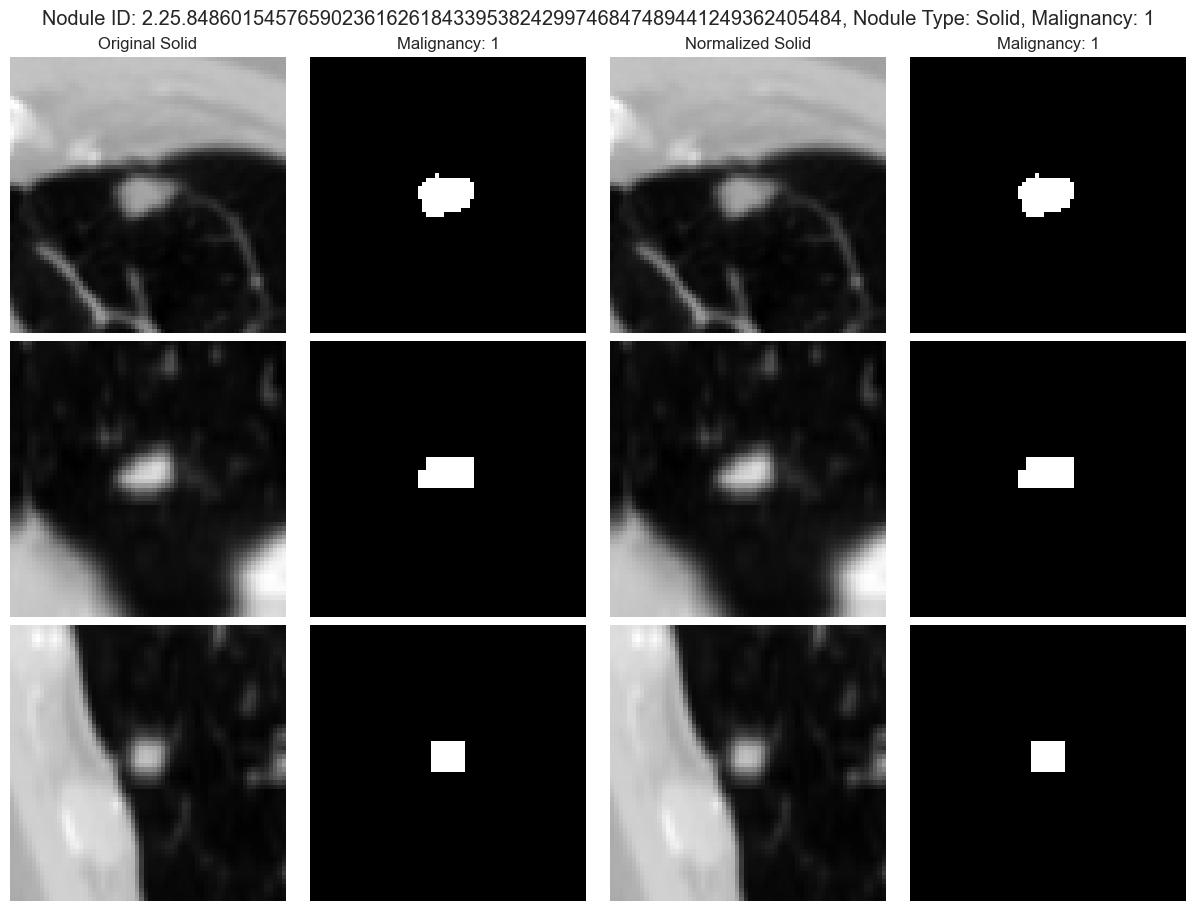

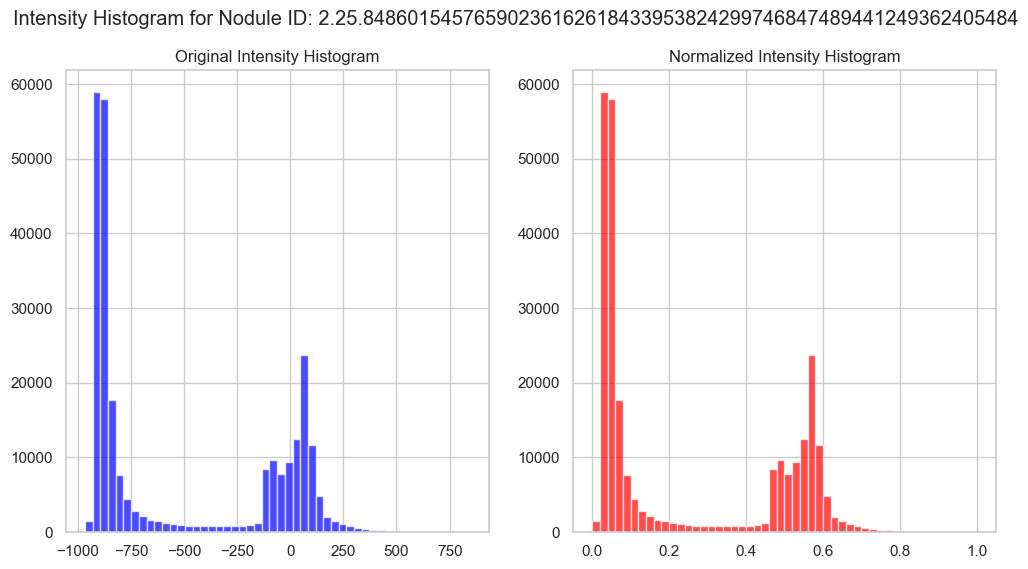

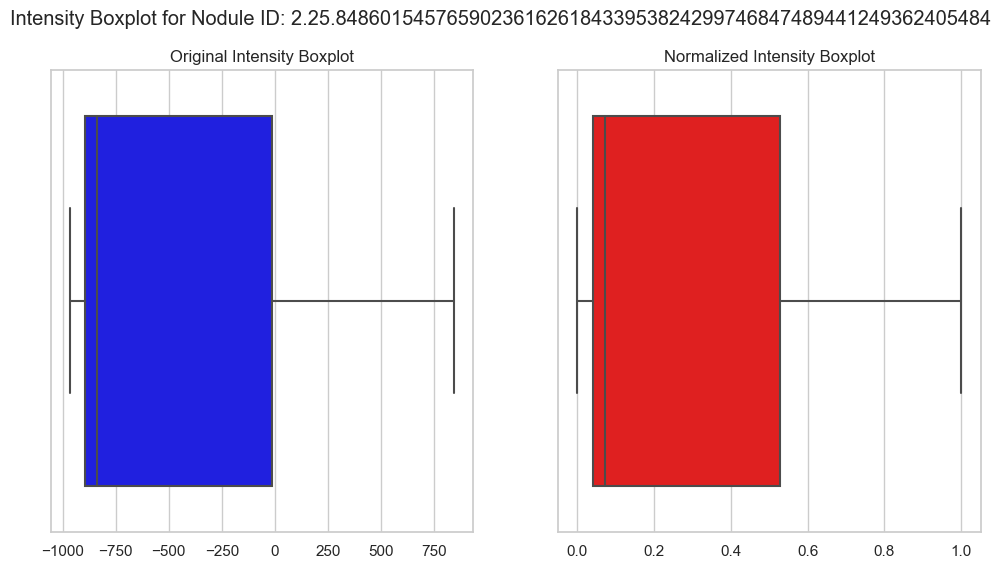

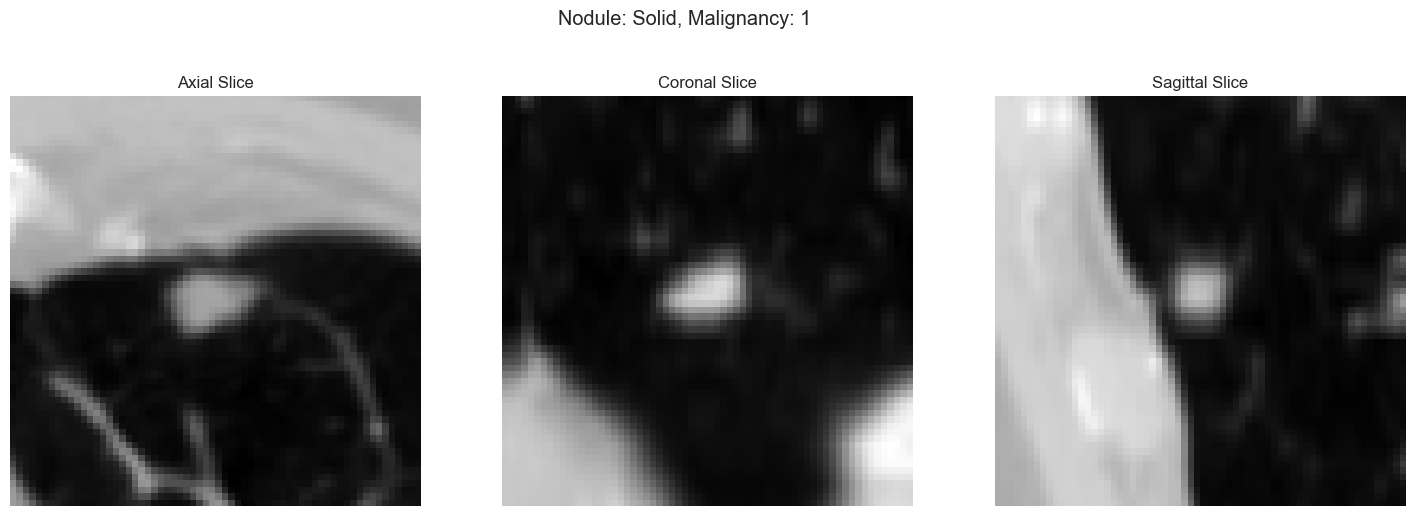

Nodule ID: 2.25.10065622643515283788217063512472949391986395994985157480903, Nodule Type: Solid, Malignancy: 1
Original Intensity Range: min=-966, max=755
Normalized Intensity Range: min=0.0, max=1.0


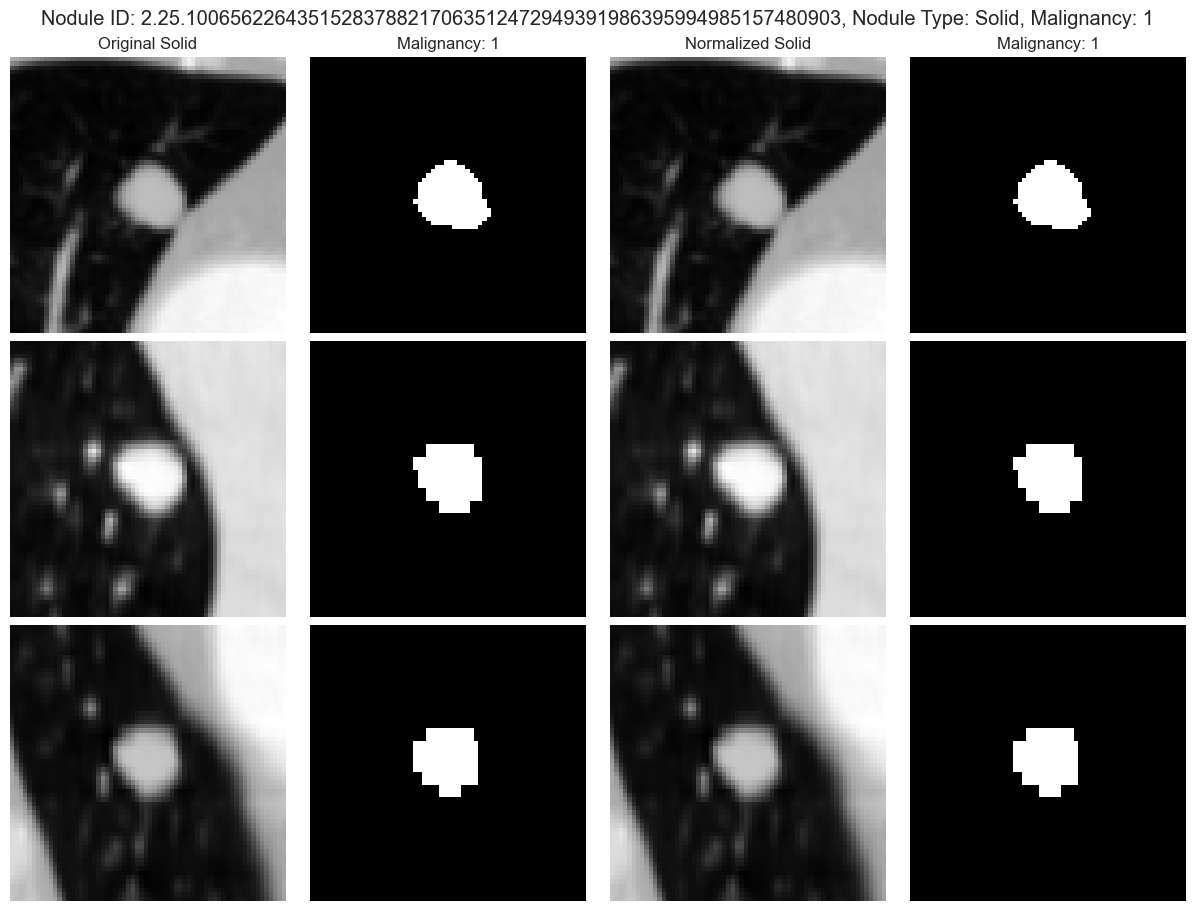

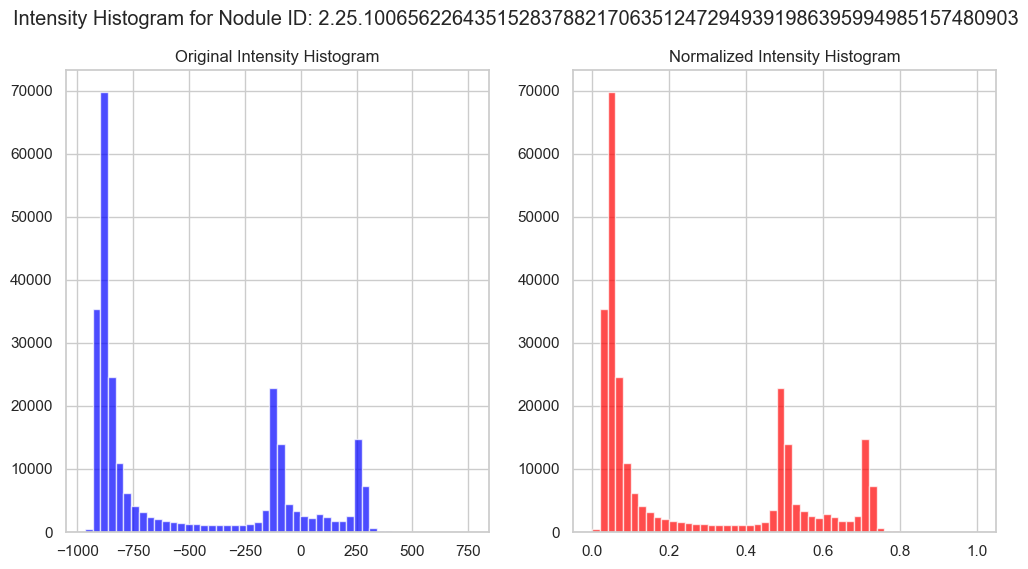

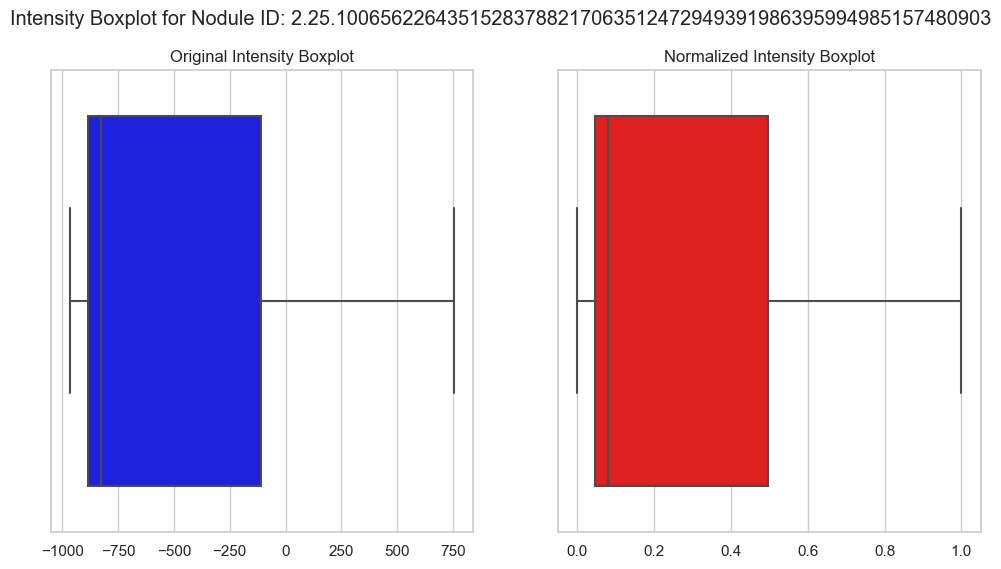

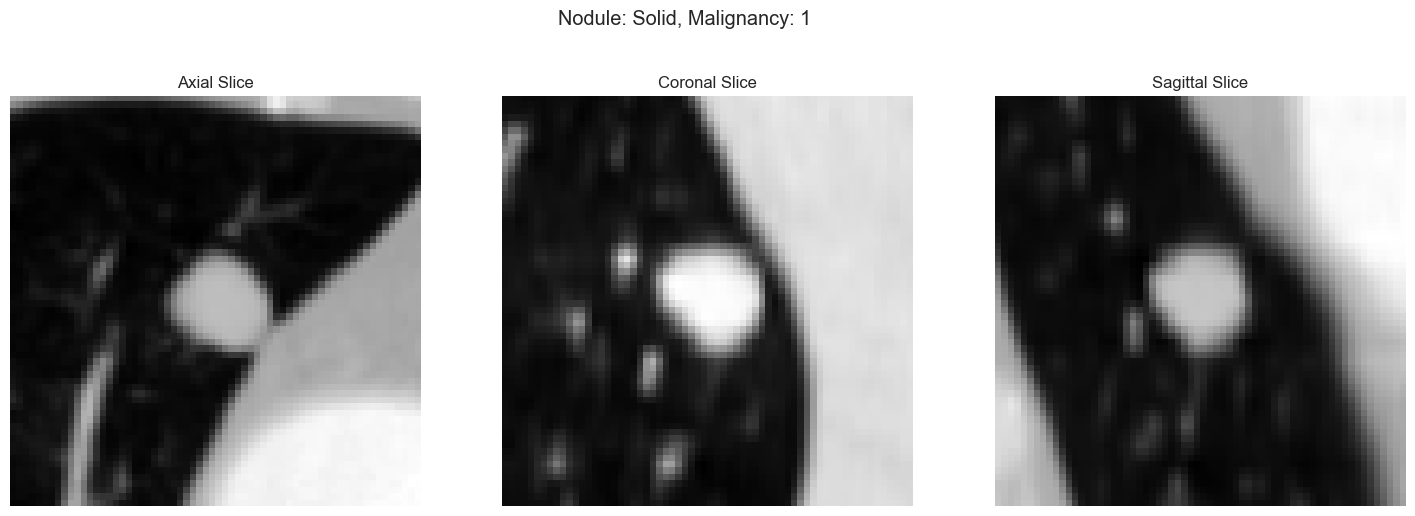

Nodule ID: 2.25.95629372200840031547341118337499101207178133424131159384366, Nodule Type: Calcified, Malignancy: 0
Original Intensity Range: min=-930, max=944
Normalized Intensity Range: min=0.0, max=1.0


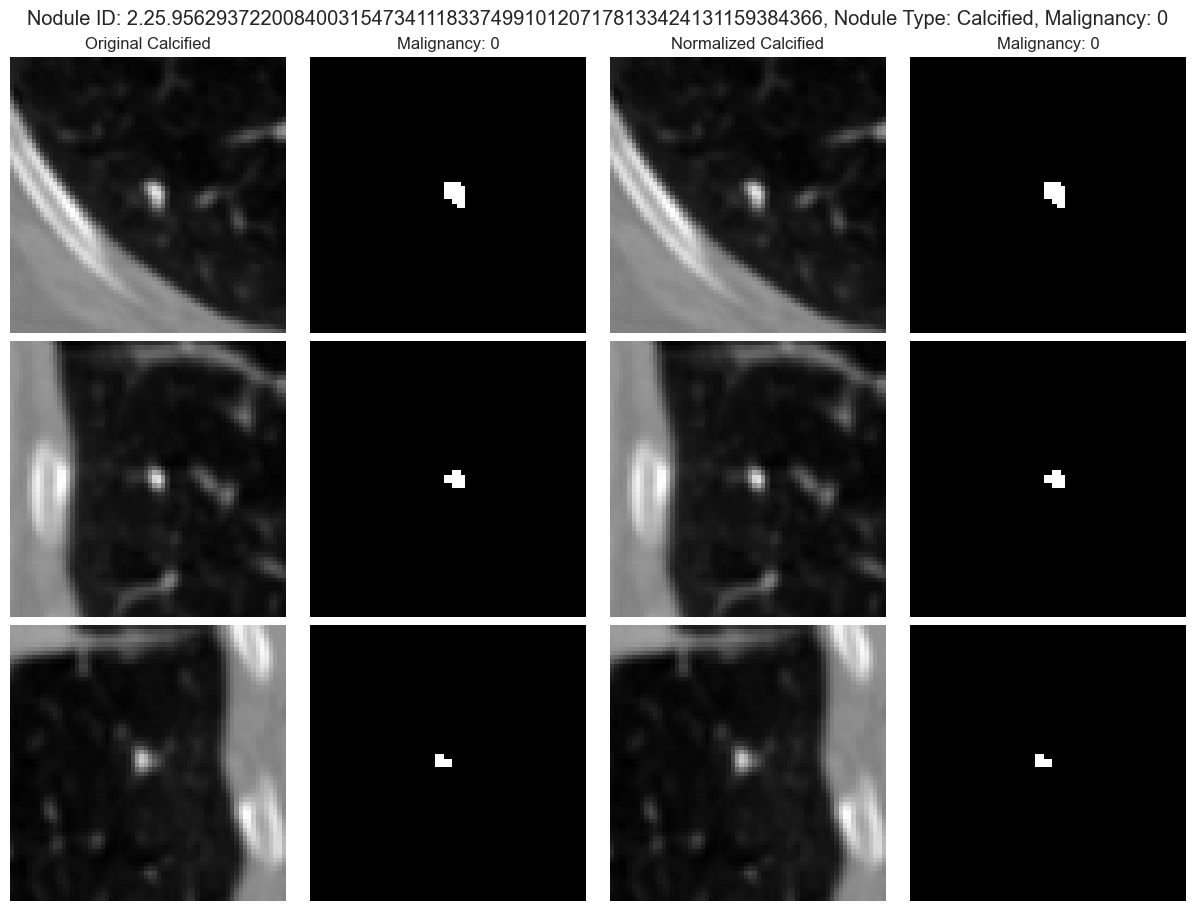

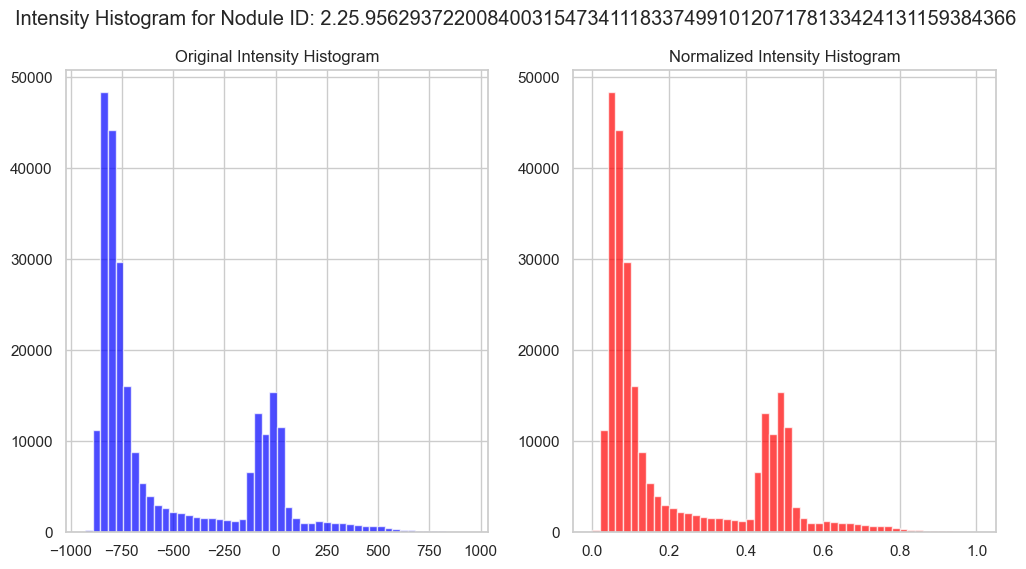

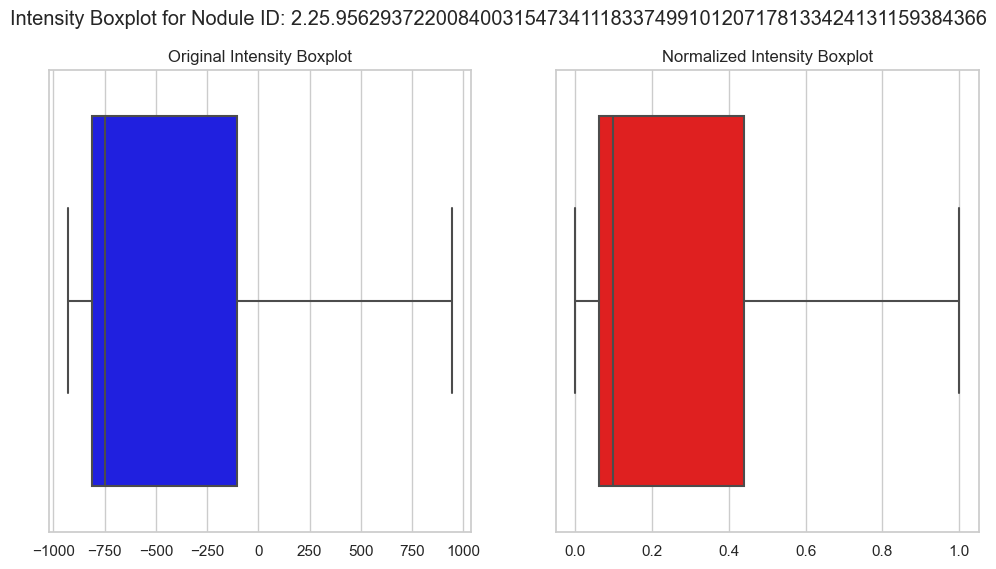

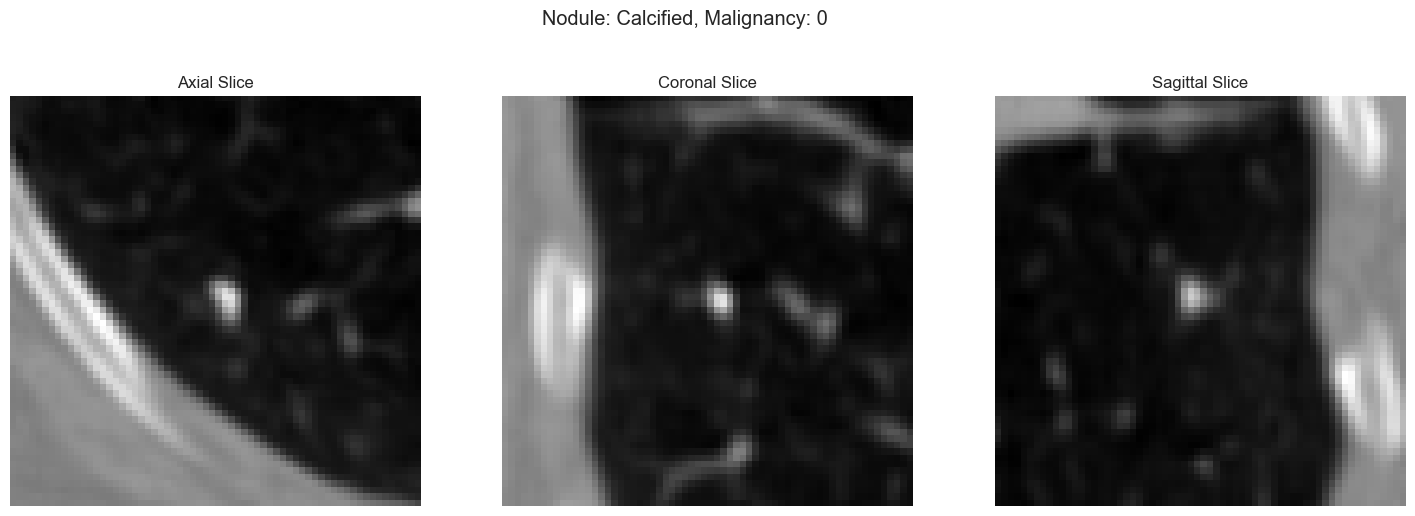

Nodule ID: 2.25.97099667116516608279598224761140048066596833669083392976608, Nodule Type: Solid, Malignancy: 0
Original Intensity Range: min=-953, max=1379
Normalized Intensity Range: min=0.0, max=1.0


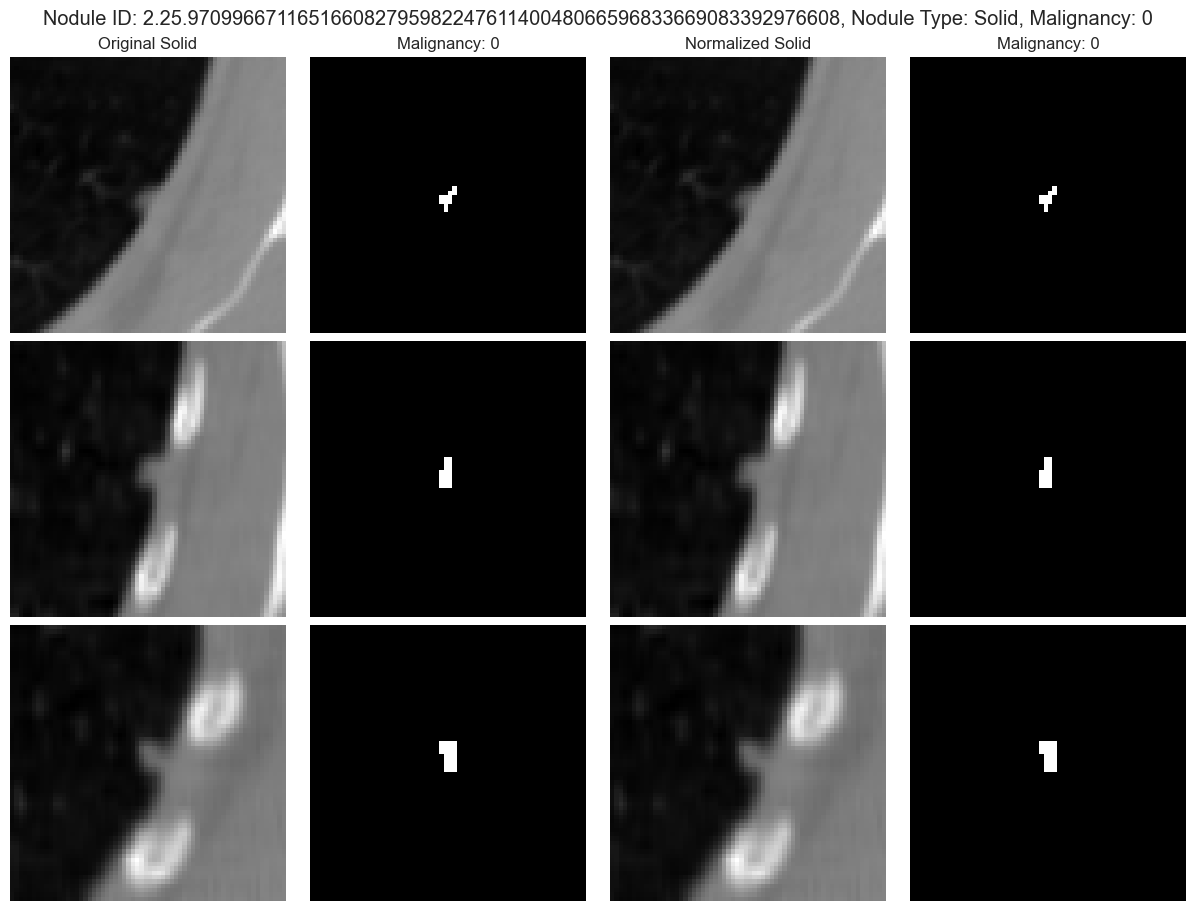

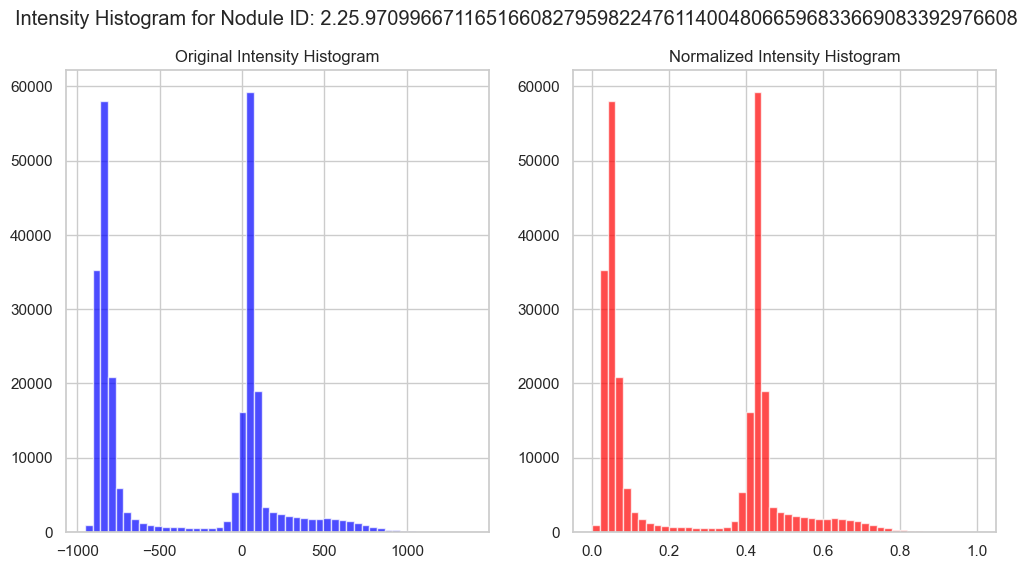

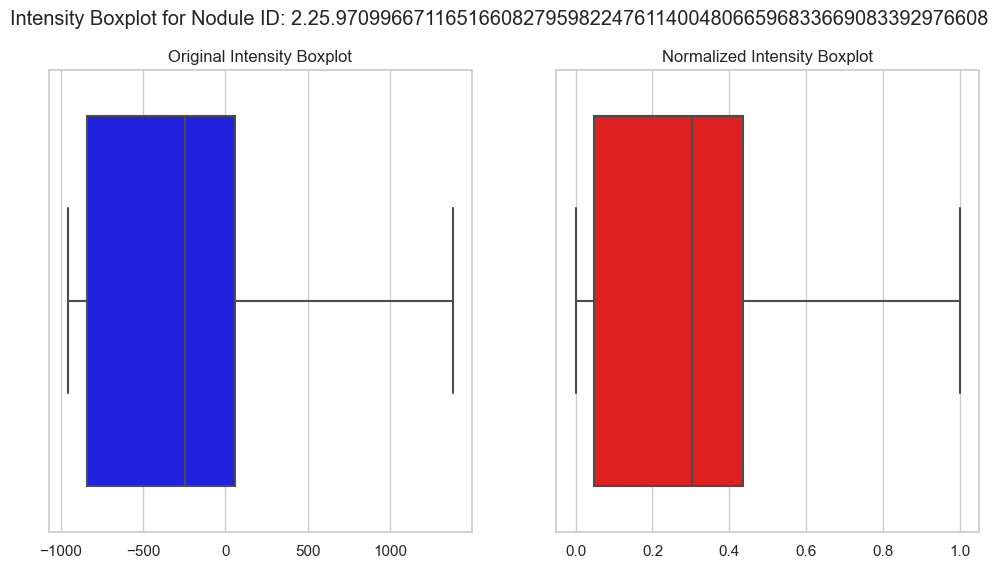

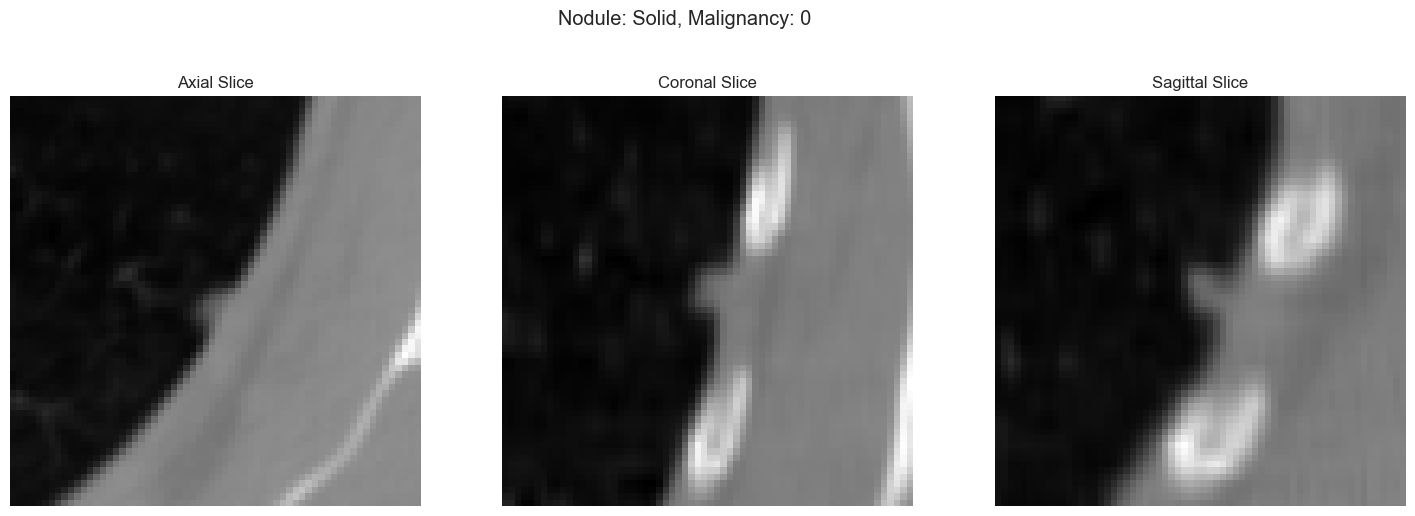

In [28]:
# Normalization Function
def normalize(image_array):
    min_intensity = np.min(image_array)
    max_intensity = np.max(image_array)
    return (image_array - min_intensity) / (max_intensity - min_intensity)


# Visualization of Patches
for i in range(5):
    pd = train_df.iloc[i]
    image = sitk.ReadImage(str(train_images_path / f"{pd.noduleid}.mha"))
    label = sitk.ReadImage(str(train_labels_path / f"{pd.noduleid}.mha"))

    image_patch, label_patch = extract_patch(
        CTData=sitk.GetArrayFromImage(image),
        coord=(32, 64, 64),
        srcVoxelOrigin=(0, 0, 0),
        srcWorldMatrix=np.array(np.flip(image.GetDirection())).reshape(3, 3),
        srcVoxelSpacing=np.flip(image.GetSpacing()),
        mask=sitk.GetArrayFromImage(label),
    )

    normalized_image_patch = normalize(image_patch[0])

    # Intensity Range
    print(f"Nodule ID: {pd.noduleid}, Nodule Type: {pd.noduletype}, Malignancy: {pd.malignancy}")
    print(f"Original Intensity Range: min={np.min(image_patch[0])}, max={np.max(image_patch[0])}")
    print(f"Normalized Intensity Range: min={np.min(normalized_image_patch)}, max={np.max(normalized_image_patch)}")

    # 2D Image Patches and Labels
    fig, ax = plt.subplots(3, 4, figsize=(12, 9), constrained_layout=True)
    fig.suptitle(f"Nodule ID: {pd.noduleid}, Nodule Type: {pd.noduletype}, Malignancy: {pd.malignancy}")

    # Original images
    ax[0, 0].imshow(image_patch[0, 32], cmap="gray")
    ax[0, 1].imshow(label_patch[0, 32], cmap="gray")
    ax[1, 0].imshow(image_patch[0, :, 32], cmap="gray")
    ax[1, 1].imshow(label_patch[0, :, 32], cmap="gray")
    ax[2, 0].imshow(image_patch[0, :, :, 32], cmap="gray")
    ax[2, 1].imshow(label_patch[0, :, :, 32], cmap="gray")

    # Normalized images
    ax[0, 2].imshow(normalized_image_patch[32], cmap="gray")
    ax[0, 3].imshow(label_patch[0, 32], cmap="gray")
    ax[1, 2].imshow(normalized_image_patch[:, 32], cmap="gray")
    ax[1, 3].imshow(label_patch[0, :, 32], cmap="gray")
    ax[2, 2].imshow(normalized_image_patch[:, :, 32], cmap="gray")
    ax[2, 3].imshow(label_patch[0, :, :, 32], cmap="gray")

    ax[0, 0].set_title(f"Original {pd.noduletype}")
    ax[0, 1].set_title(f"Malignancy: {pd.malignancy}")
    ax[0, 2].set_title(f"Normalized {pd.noduletype}")
    ax[0, 3].set_title(f"Malignancy: {pd.malignancy}")

    [ax[a][b].axis("off") for a in range(3) for b in range(4)]
    plt.show()

    # Histogram of intensities
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f"Intensity Histogram for Nodule ID: {pd.noduleid}")

    ax[0].hist(image_patch[0].flatten(), bins=50, color='blue', alpha=0.7, label='Original')
    ax[0].set_title('Original Intensity Histogram')

    ax[1].hist(normalized_image_patch.flatten(), bins=50, color='red', alpha=0.7, label='Normalized')
    ax[1].set_title('Normalized Intensity Histogram')

    plt.show()

    # Boxplot of intensities
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f"Intensity Boxplot for Nodule ID: {pd.noduleid}")

    sns.boxplot(x=image_patch[0].flatten(), color='blue', ax=ax[0])
    ax[0].set_title('Original Intensity Boxplot')

    sns.boxplot(x=normalized_image_patch.flatten(), color='red', ax=ax[1])
    ax[1].set_title('Normalized Intensity Boxplot')

    plt.show()

    # Slice-wise analysis
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f"Nodule: {pd.noduletype}, Malignancy: {pd.malignancy}")

    axs[0].imshow(image_patch[0, 32], cmap='gray')
    axs[0].set_title('Axial Slice')
    axs[1].imshow(image_patch[0, :, 32], cmap='gray')
    axs[1].set_title('Coronal Slice')
    axs[2].imshow(image_patch[0, :, :, 32], cmap='gray')
    axs[2].set_title('Sagittal Slice')

    for ax in axs:
        ax.axis('off')
    plt.show()

    # # 3D Voxel Visualization
    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    # 
    # # Focus on the nodule only
    # nodule_only = normalized_image_patch > 0.1  # Thresholding to highlight the nodule
    # ax.voxels(nodule_only, facecolors='blue', edgecolor='k')
    # 
    # ax.set_xlabel('X-axis (Columns)')
    # ax.set_ylabel('Y-axis (Rows)')
    # ax.set_zlabel('Z-axis (Slices)')

    plt.show()

## Data Augmentation
### Step 1: Apply and Visualize Augmentations
First, let's visualize each augmentation technique on a few examples from the minority classes (GroundGlassOpacity, SemiSolid).

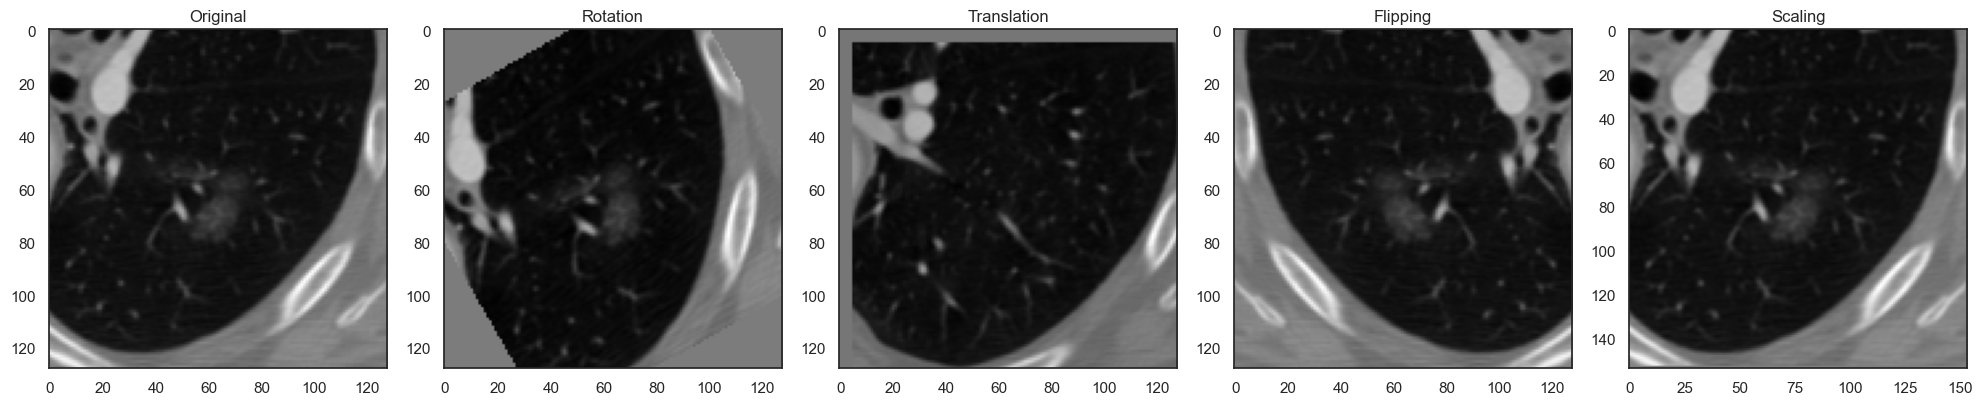

In [32]:
import pandas as pd

sns.set_style("white")

# Load data paths
train_images_path = Path("../data/train_set/images/")
train_df = pd.read_csv("../data/luna23-ismi-train-set.csv")


# Load a sample image
def load_sample_image(nodule_id):
    image = sitk.ReadImage(str(train_images_path / f"{nodule_id}.mha"))
    image_patch = sitk.GetArrayFromImage(image)
    return image_patch


# Define augmentation functions
def apply_rotation(image, angle):
    return rotate(image, angle, axes=(1, 2), reshape=False)


def apply_translation(image, shift_val):
    return shift(image, shift_val)


def apply_flipping(image, axis):
    return np.flip(image, axis=axis)


def apply_scaling(image, scale):
    return zoom(image, scale)


# Load sample images
ground_glass_sample = load_sample_image(train_df[train_df['noduletype'] == 'GroundGlassOpacity'].iloc[0]['noduleid'])
semi_solid_sample = load_sample_image(train_df[train_df['noduletype'] == 'SemiSolid'].iloc[0]['noduleid'])

# Define and apply augmentations
augmentations = {
    "Rotation": apply_rotation(ground_glass_sample, 30),
    "Translation": apply_translation(ground_glass_sample, (5, 5, 5)),
    "Flipping": apply_flipping(ground_glass_sample, axis=2),
    "Scaling": apply_scaling(ground_glass_sample, (1, 1.2, 1.2))
}

# Visualize augmentations
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
ax[0].imshow(ground_glass_sample[32], cmap='gray')
ax[0].set_title('Original')

for i, (aug_name, aug_img) in enumerate(augmentations.items()):
    ax[i + 1].imshow(aug_img[32], cmap='gray')
    ax[i + 1].set_title(aug_name)

plt.tight_layout()
plt.show()

### Step 2: Balancing for Nodule Types
Next, we will balance the dataset by augmenting the minority classes (GroundGlassOpacity, SemiSolid) to match the majority class (Solid).

In [33]:
# Function to augment dataset for specific class
def augment_class(train_df, train_images_path, target_class, class_column, target_count):
    augmented_data = []
    class_df = train_df[train_df[class_column] == target_class]
    for _, row in tqdm(class_df.iterrows(), total=len(class_df)):
        image_patch = load_sample_image(row['noduleid'])
        for _ in range(target_count // len(class_df)):
            augmented_image = apply_rotation(image_patch, np.random.uniform(-30, 30))
            augmented_image = apply_translation(augmented_image, np.random.uniform(-5, 5, size=3))
            augmented_image = apply_flipping(augmented_image, axis=np.random.choice([0, 1, 2]))
            augmented_image = apply_scaling(augmented_image,
                                            (1, np.random.uniform(0.9, 1.1), np.random.uniform(0.9, 1.1)))
            augmented_data.append((augmented_image, row))
    return augmented_data


# Define target count based on majority class for nodule types
target_count_noduletype = train_df['noduletype'].value_counts().max()

# Augment dataset for nodule types
augmented_data_noduletype = []
for target_class in train_df['noduletype'].value_counts().index:
    if train_df['noduletype'].value_counts()[target_class] < target_count_noduletype:
        augmented_data_noduletype.extend(
            augment_class(train_df, train_images_path, target_class, 'noduletype', target_count_noduletype))

# Convert augmented data to DataFrame
augmented_rows = []
for augmented_image, original_row in augmented_data_noduletype:
    new_row = original_row.copy()
    new_row['noduleid'] = f"aug_nodule_{len(augmented_rows)}"
    augmented_rows.append(new_row)

augmented_df_noduletype = pd.DataFrame(augmented_rows)

# Concatenate with original dataset
balanced_train_df_noduletype = pd.concat([train_df, augmented_df_noduletype])

100%|██████████| 18/18 [06:24<00:00, 21.33s/it]


### Step 3: Balancing for Malignancy Labels
Next, we will balance the dataset by augmenting the minority class (1) to match the majority class (0).

In [34]:
# Define target count based on majority class for malignancy
target_count_malignancy = train_df['malignancy'].value_counts().max()

# Augment dataset for malignancy
augmented_data_malignancy = []
for target_class in train_df['malignancy'].value_counts().index:
    if train_df['malignancy'].value_counts()[target_class] < target_count_malignancy:
        augmented_data_malignancy.extend(
            augment_class(train_df, train_images_path, target_class, 'malignancy', target_count_malignancy))

# Convert augmented data to DataFrame
augmented_rows_malignancy = []
for augmented_image, original_row in augmented_data_malignancy:
    new_row = original_row.copy()
    new_row['noduleid'] = f"aug_nodule_{len(augmented_rows_malignancy)}"
    augmented_rows_malignancy.append(new_row)

augmented_df_malignancy = pd.DataFrame(augmented_rows_malignancy)

# Concatenate with original dataset
balanced_train_df_malignancy = pd.concat([train_df, augmented_df_malignancy])

100%|██████████| 212/212 [06:02<00:00,  1.71s/it]


### Step 4: Verify and Analyze the Balancing
Let's now verify the balancing by analyzing the class distributions and proportions.

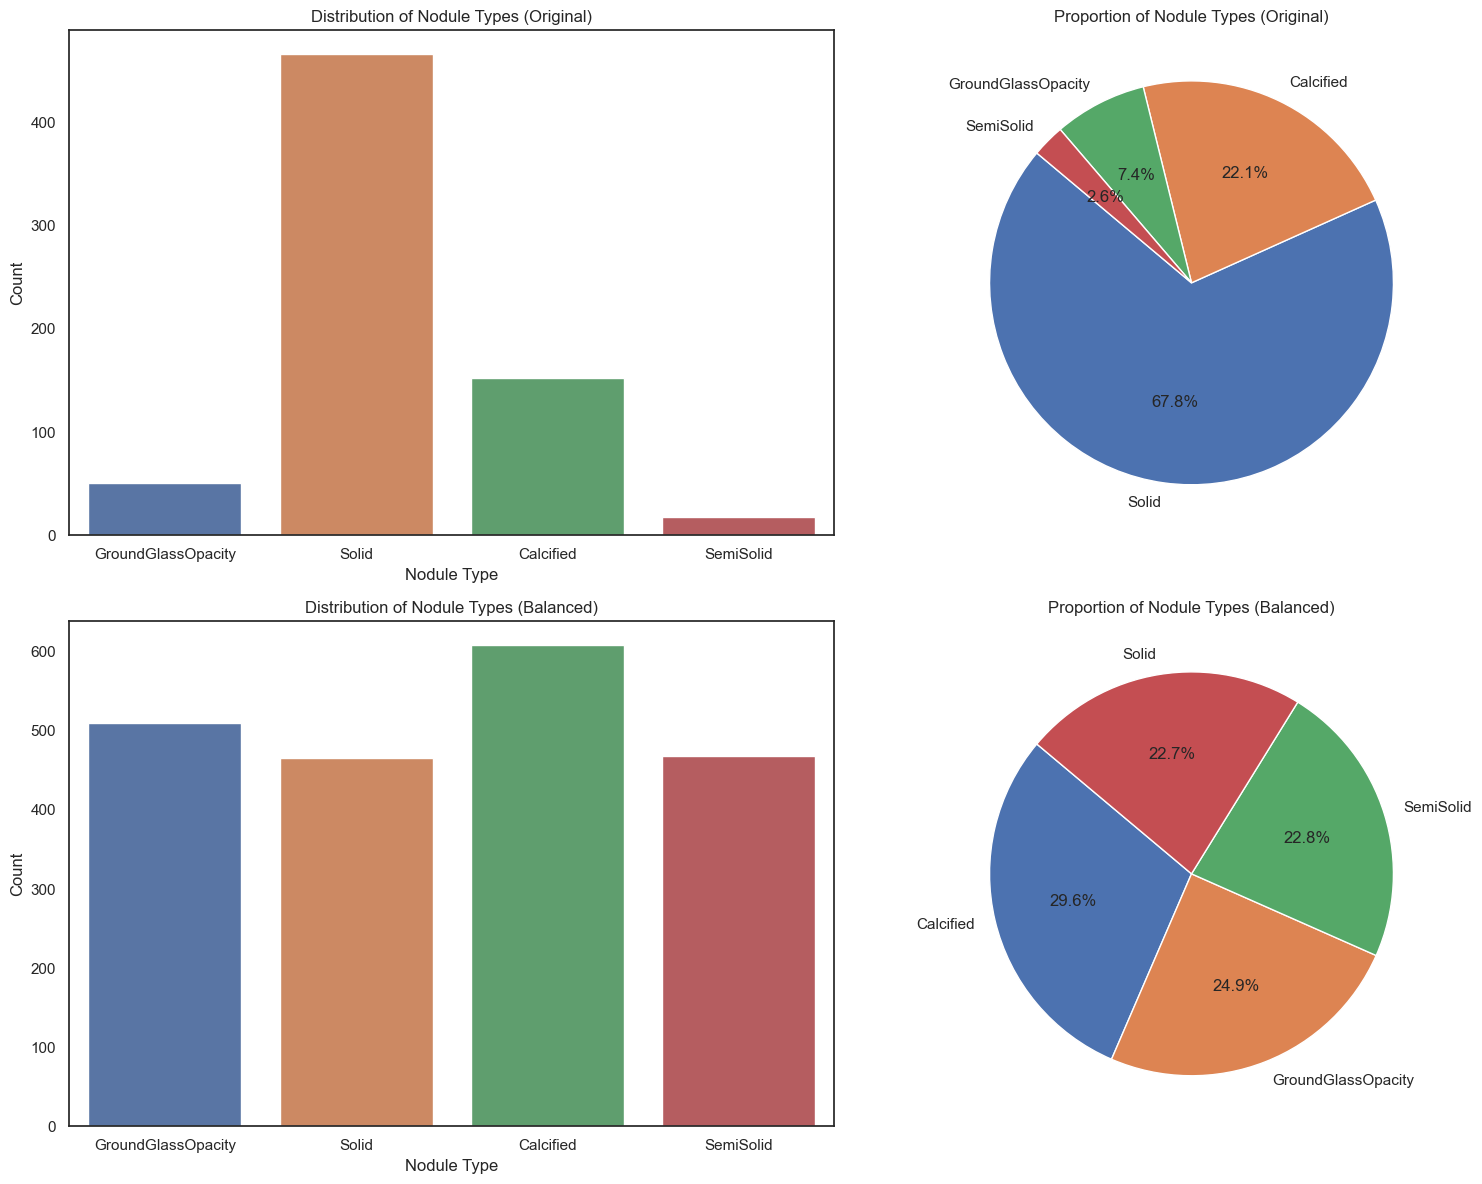

Nodule Type Percentages
Nodule Type Percentages (Original):
Solid                 67.831150
Calcified             22.125182
GroundGlassOpacity     7.423581
SemiSolid              2.620087
Name: noduletype, dtype: float64

Nodule Type Percentages (Balanced):
Calcified             29.629630
GroundGlassOpacity    24.853801
SemiSolid             22.807018
Solid                 22.709552
Name: noduletype, dtype: float64


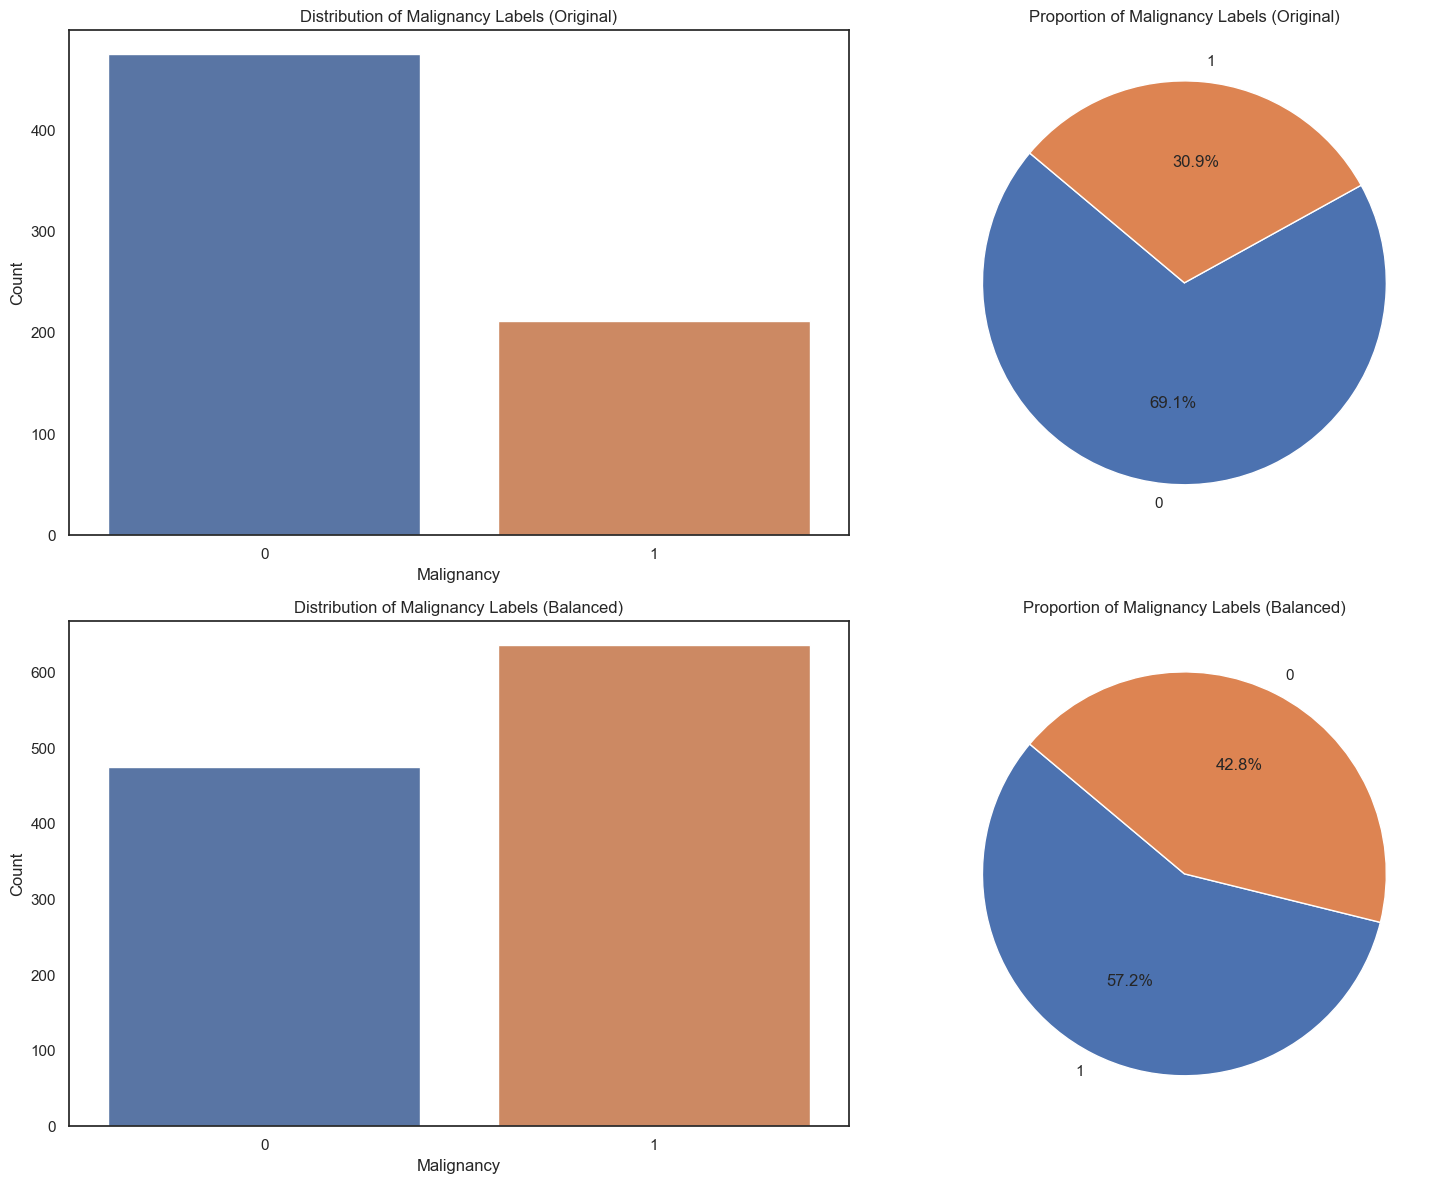


Malignancy Percentages
Malignancy Percentages (Original):
0    69.141194
1    30.858806
Name: malignancy, dtype: float64

Malignancy Percentages (Balanced):
1    57.245725
0    42.754275
Name: malignancy, dtype: float64


In [35]:
# Original Data Distribution
noduletype_counts_original = train_df['noduletype'].value_counts()
malignancy_counts_original = train_df['malignancy'].value_counts()

# Class Distribution Count Plots for Nodule Types (Before and After)
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
sns.countplot(x='noduletype', data=train_df, ax=ax[0, 0])
ax[0, 0].set_title('Distribution of Nodule Types (Original)')
ax[0, 0].set_xlabel('Nodule Type')
ax[0, 0].set_ylabel('Count')
ax[0, 1].pie(noduletype_counts_original, labels=noduletype_counts_original.index, autopct='%1.1f%%', startangle=140)
ax[0, 1].set_title('Proportion of Nodule Types (Original)')

sns.countplot(x='noduletype', data=balanced_train_df_noduletype, ax=ax[1, 0])
ax[1, 0].set_title('Distribution of Nodule Types (Balanced)')
ax[1, 0].set_xlabel('Nodule Type')
ax[1, 0].set_ylabel('Count')
noduletype_counts_noduletype_balanced = balanced_train_df_noduletype['noduletype'].value_counts()
ax[1, 1].pie(noduletype_counts_noduletype_balanced, labels=noduletype_counts_noduletype_balanced.index,
             autopct='%1.1f%%', startangle=140)
ax[1, 1].set_title('Proportion of Nodule Types (Balanced)')

plt.tight_layout()
plt.show()

print("Nodule Type Percentages")
print("Nodule Type Percentages (Original):")
print(noduletype_counts_original / noduletype_counts_original.sum() * 100)
print("\nNodule Type Percentages (Balanced):")
print(noduletype_counts_noduletype_balanced / noduletype_counts_noduletype_balanced.sum() * 100)

# Class Distribution Count Plots for Malignancy (Before and After)
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
sns.countplot(x='malignancy', data=train_df, ax=ax[0, 0])
ax[0, 0].set_title('Distribution of Malignancy Labels (Original)')
ax[0, 0].set_xlabel('Malignancy')
ax[0, 0].set_ylabel('Count')
ax[0, 1].pie(malignancy_counts_original, labels=malignancy_counts_original.index, autopct='%1.1f%%', startangle=140)
ax[0, 1].set_title('Proportion of Malignancy Labels (Original)')

sns.countplot(x='malignancy', data=balanced_train_df_malignancy, ax=ax[1, 0])
ax[1, 0].set_title('Distribution of Malignancy Labels (Balanced)')
ax[1, 0].set_xlabel('Malignancy')
ax[1, 0].set_ylabel('Count')
malignancy_counts_malignancy_balanced = balanced_train_df_malignancy['malignancy'].value_counts()
ax[1, 1].pie(malignancy_counts_malignancy_balanced, labels=malignancy_counts_malignancy_balanced.index,
             autopct='%1.1f%%', startangle=140)
ax[1, 1].set_title('Proportion of Malignancy Labels (Balanced)')

plt.tight_layout()
plt.show()

print("\nMalignancy Percentages")
print("Malignancy Percentages (Original):")
print(malignancy_counts_original / malignancy_counts_original.sum() * 100)
print("\nMalignancy Percentages (Balanced):")
print(malignancy_counts_malignancy_balanced / malignancy_counts_malignancy_balanced.sum() * 100)